In [2]:
!pip install kaggle



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\Laura\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import kagglehub
import numpy as np
import re

from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

file_path = kagglehub.dataset_download("mexwell/amazon-reviews-multi")
csv_path = file_path + "/train.csv"

df = pd.read_csv(csv_path, encoding="latin-1")

print("Shape:", df.shape)
print("Columnas:", df.columns)
print(df.head())

Shape: (1200000, 9)
Columnas: Index(['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars',
       'review_body', 'review_title', 'language', 'product_category'],
      dtype='object')
   Unnamed: 0   review_id          product_id          reviewer_id  stars  \
0           0  de_0203609  product_de_0865382  reviewer_de_0267719      1   
1           1  de_0559494  product_de_0678997  reviewer_de_0783625      1   
2           2  de_0238777  product_de_0372235  reviewer_de_0911426      1   
3           3  de_0477884  product_de_0719501  reviewer_de_0836478      1   
4           4  de_0270868  product_de_0022613  reviewer_de_0736276      1   

                                         review_body  \
0     Armband ist leider nach 1 Jahr kaputt gegangen   
1                 In der Lieferung war nur Ein Akku!   
2  Ein Stern, weil gar keine geht nicht. Es hande...   
3  Dachte, das wÃ¤ren einfach etwas festere Binde...   
4  Meine Kinder haben kaum damit gespielt und nac...   

     

In [4]:
#Preprocesamiento

df["text"] = df["review_title"].fillna("") + " " + df["review_body"].fillna("")
df["labels"] = df["stars"] - 1
df = df[["text", "labels", "language"]]
dataset = Dataset.from_pandas(df)

# Splits
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_val = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = train_val["train"]
validation_dataset = train_val["test"]
test_dataset = dataset["test"]

print("Splits:")
print("Train:", train_dataset.shape)
print("Validation:", validation_dataset.shape)
print("Test:", test_dataset.shape)

Splits:
Train: (972000, 3)
Validation: (108000, 3)
Test: (120000, 3)


In [5]:
#Tokenización
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.unk_token

def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=180
    )

train_dataset = train_dataset.map(preprocess, batched=True)
validation_dataset = validation_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

train_dataset = train_dataset.remove_columns(["text", "language"])
validation_dataset = validation_dataset.remove_columns(["text", "language"])
test_dataset = test_dataset.remove_columns(["text", "language"])

train_dataset.set_format(type="torch")
validation_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")


Map:   0%|          | 0/972000 [00:00<?, ? examples/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [5]:
#Fine-tunning de RoBERTa
id2label = {i: f"{i+1}_stars" for i in range(5)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id
)


#Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0)
    }


training_args = TrainingArguments(
    output_dir="./xlm-roberta-amazon",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    warmup_ratio=0.10,
    weight_decay=0.01,
    seed=42,
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print(" Iniciando entrenamiento...")
train_result = trainer.train(resume_from_checkpoint=True)
print("\n Entrenamiento finalizado. Métricas:")
print(train_result.metrics)


trainer.save_model("./xlm_roberta_finetuned_amazon")
print("Modelo guardado correctamente.")

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3a6f15d6-e745-4139-8c7d-489b99b05235)')' thrown while requesting HEAD https://huggingface.co/xlm-roberta-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Laura\AppData\Local\Temp\ipykernel_22480\2930478216.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 Iniciando entrenamiento...


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
5,0.820000,0.953695,0.600972,0.598554,0.600761,0.599094



 Entrenamiento finalizado. Métricas:
{'train_runtime': 20783.6042, 'train_samples_per_second': 233.838, 'train_steps_per_second': 14.615, 'total_flos': 4.495620137256e+17, 'train_loss': 0.16399483024691358, 'epoch': 5.0}
Modelo guardado correctamente.


In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
import numpy as np

# Carga el mejor modelo
model_path = "./xlm_roberta_finetuned_amazon"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)

# Evaluación final en test
metrics_test = trainer.evaluate(test_dataset)
metrics_test


The tokenizer you are loading from './xlm_roberta_finetuned_amazon' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
C:\Users\Laura\AppData\Local\Temp\ipykernel_17140\3492802954.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.948747456073761,
 'eval_model_preparation_time': 0.0021,
 'eval_runtime': 619.3569,
 'eval_samples_per_second': 193.749,
 'eval_steps_per_second': 24.219}

In [7]:
from sklearn.metrics import classification_report

# Obtener logits
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_pred = np.argmax(logits, axis=1)
y_true = predictions.label_ids

print(classification_report(y_true, y_pred, target_names=[f"{i+1} estrellas" for i in range(5)]))


              precision    recall  f1-score   support

 1 estrellas       0.70      0.71      0.71     23756
 2 estrellas       0.50      0.54      0.52     23804
 3 estrellas       0.52      0.48      0.50     24118
 4 estrellas       0.56      0.52      0.54     24153
 5 estrellas       0.70      0.75      0.73     24169

    accuracy                           0.60    120000
   macro avg       0.60      0.60      0.60    120000
weighted avg       0.60      0.60      0.60    120000



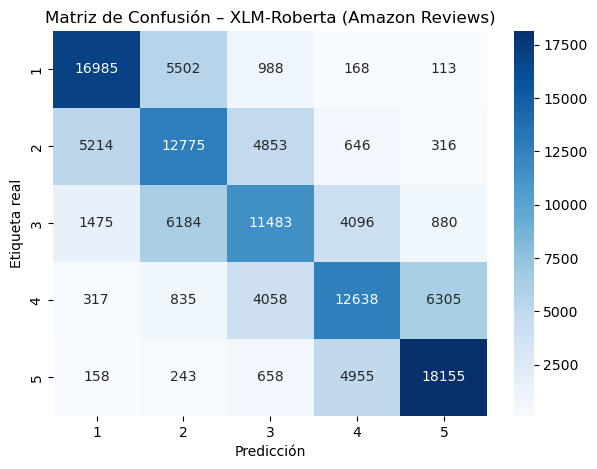

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(5)],
            yticklabels=[f"{i+1}" for i in range(5)])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión – XLM-Roberta (Amazon Reviews)")
plt.show()

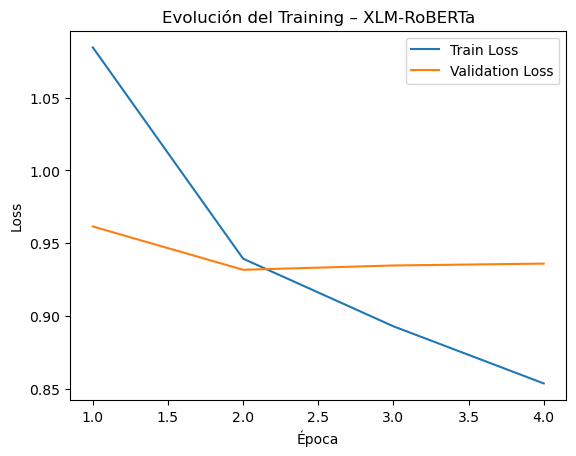

In [11]:
import json
import matplotlib.pyplot as plt

# Cargar historial del training
with open("./xlm-roberta-amazon/checkpoint-243000/trainer_state.json", "r") as f:
    state = json.load(f)

log_history = state["log_history"]

epochs, train_loss, val_loss, f1 = [], [], [], []

for log in log_history:
    if "loss" in log and "epoch" in log:
        epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
        f1.append(log["eval_f1_macro"])

plt.plot(epochs[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(epochs[:len(val_loss)], val_loss, label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolución del Training – XLM-RoBERTa")
plt.legend()
plt.show()


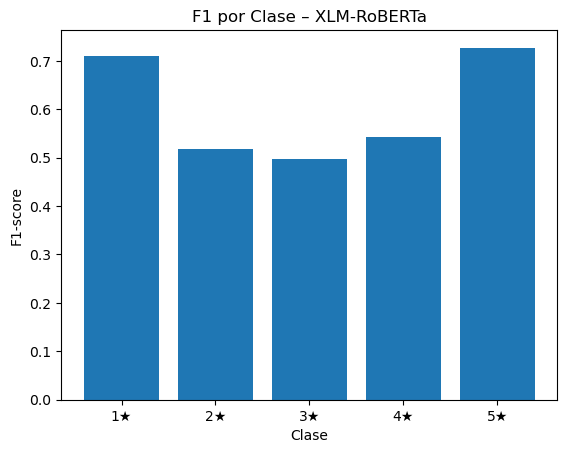

In [13]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

labels = [f"{i+1}★" for i in range(5)]

plt.bar(labels, f1)
plt.xlabel("Clase")
plt.ylabel("F1-score")
plt.title("F1 por Clase – XLM-RoBERTa")
plt.show()


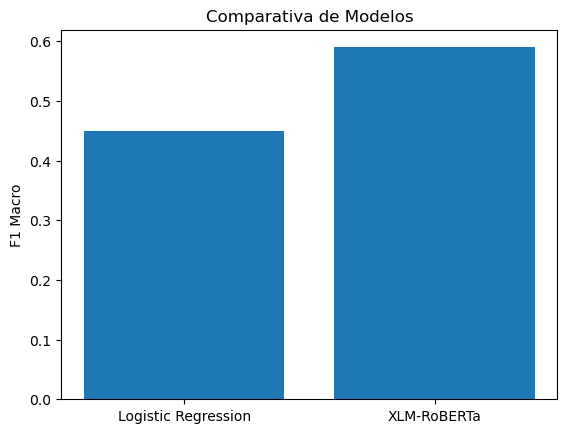

In [14]:
models = ["Logistic Regression", "XLM-RoBERTa"]
f1_scores = [0.45, 0.59]  # Pon tus valores reales
accuracies = [0.50, 0.60]

plt.bar(models, f1_scores)
plt.ylabel("F1 Macro")
plt.title("Comparativa de Modelos")
plt.show()

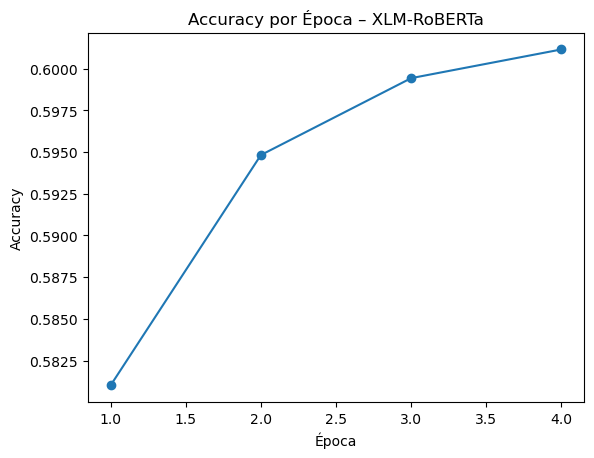

In [15]:
import json
import matplotlib.pyplot as plt

# Cargar el trainer_state
with open("./xlm-roberta-amazon/checkpoint-243000/trainer_state.json", "r") as f:
    state = json.load(f)

log_history = state["log_history"]

epochs, acc = [], []

for log in log_history:
    if "eval_accuracy" in log:
        epochs.append(log["epoch"])
        acc.append(log["eval_accuracy"])

plt.plot(epochs, acc, marker="o")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy por Época – XLM-RoBERTa")
plt.show()
